# Assignment

## Importing Libraries

In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
import my_utils as mu

## Loading the Datasets

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
classes = ()

## Creating the training dataset

In [12]:
from torch.utils.data import DataLoader
batch_size = 100

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True,num_workers=2)

In [13]:
X,y = next(iter(train_iter))

## Creating the test dataset

In [14]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=False,num_workers=2)

In [15]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [16]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([100, 3, 32, 32]) The number of input channels is 3
The output labels are as follows tensor([1, 8, 9, 0, 0, 0, 9, 7, 1, 0, 2, 0, 5, 8, 8, 1, 2, 2, 9, 9, 5, 8, 0, 4,
        4, 9, 8, 2, 2, 7, 9, 5, 9, 6, 3, 0, 6, 6, 4, 3, 9, 2, 5, 7, 3, 7, 6, 3,
        3, 4, 4, 6, 3, 7, 4, 9, 6, 5, 4, 2, 9, 7, 1, 4, 0, 6, 4, 8, 8, 5, 8, 8,
        2, 5, 4, 8, 8, 6, 4, 8, 8, 1, 4, 3, 0, 2, 8, 8, 6, 9, 4, 0, 4, 6, 3, 8,
        9, 3, 6, 4])


## Example image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


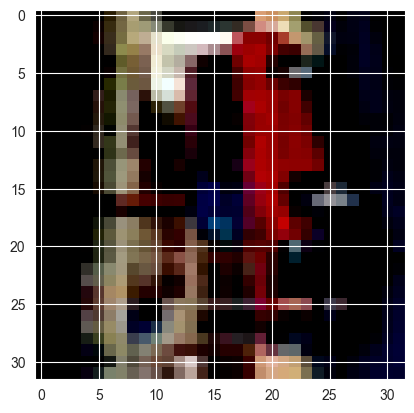

In [17]:
plt.imshow(X[0].T)

## CNN Architecture

In [18]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        self.batch_norm_input = torch.nn.BatchNorm2d(3)

        #Spatial/Global Pooling for input-------------------------------------------------------
        self.spatial_avg_pool1 = torch.nn.AvgPool2d(kernel_size=24,stride=1)

        # Design the base block Element---------------------------------------------------------
        #Create an input linear layer for future combination
        self.initial_block_linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=24300,out_features=3),
            torch.nn.ReLU(),
            torch.nn.Dropout(0)
        )

        self.initial_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=10,kernel_size=3,stride=1,padding=1),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU()

        )

        self.second_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=10,kernel_size=4,stride=1,padding=1),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU()
        )

        self.third_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=10,kernel_size=5,stride=3,padding=1),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU()
        )

        # Create the spatial average pooling layer for the inputs to the dense---------------------
        self.spatial_avg_pool2 = torch.nn.AdaptiveAvgPool1d((9612))

        # Create the dense,classification block----------------------------------------------------
        # First FC linear layer
        self.initial_fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=9612,out_features=6948),
            torch.nn.ReLU(),
            torch.nn.Dropout(0)
        )

        # Create the final layer leading into softmax
        self.final_fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=6948,out_features=num_outputs),
            torch.nn.ReLU(),
            torch.nn.Dropout(0),
            torch.nn.Softmax(dim=1)
        )

    def forward(self,x):
        x = self.batch_norm_input(x)
        # Applying average pooling to down sample the image from 32 -> 24
        a = self.spatial_avg_pool1(x)

        # First Block------------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a = torch.flatten(a)
        a = self.initial_block_linear(a)

        # Get outputs of each convolution ->RelU layer
        o1 = self.initial_block_conv(x)
        o2 = self.second_block_conv(x)
        o3 = self.third_block_conv(x)

        O = torch.concat((o1.view(100,-1),o2.view(100,-1),o3.view(100,-1)),dim=1)

        # Prepare the outputs for the second block
        O = torch.matmul(a,O.view(3,-1))

        # Apply spatial pooling before entering the dense layer------------
        O_bn = self.spatial_avg_pool2(O.view(100,-1))

        # Move to the dense/classification block
        output = self.initial_fc(O_bn.view(100,-1))

        output = self.final_fc(output)

        return output

In [19]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (batch_norm_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (spatial_avg_pool1): AvgPool2d(kernel_size=24, stride=1, padding=0)
  (initial_block_linear): Sequential(
    (0): Linear(in_features=24300, out_features=3, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (initial_block_conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (second_block_conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (third_block_conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (spatial_av

In [20]:
model(X).size()

torch.Size([100, 10])

## Create Loss and Optimization

In [21]:
loss = torch.nn.CrossEntropyLoss()

# Create the optimizer term
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,weight_decay=0.005,momentum=0.9)

## Create the metric for calculating accuracy

## ---------------------------------

In [31]:
def train_model(model,train_iter,epochs,optimizer,loss):
    for epoch in range(epochs): # Initialize the epochs

        running_loss = 0.0
        l = []

        for i,data in enumerate(train_iter,0):

            X,y = data

            optimizer.zero_grad()

            #model.train()
            y_hat = model(X)
            l = loss(y_hat,y)
            l.backward()
            optimizer.step()

            running_loss += l.item()
            if i% 2000 ==1999: # Prints every 2000 mini-batches
                print(f'[{epoch + 1},{i + 1:5d}] loss:{running_loss/2000:.3f}')
                l.append(running_loss/2000)
                running_loss = 0.0

    return

In [33]:
epochs = 5
train_model(model,train_iter,epochs,optimizer,loss)

KeyboardInterrupt: 

In [35]:
def test_model(model,test_iter):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_iter:
            X_test,y_test = data

            y_hat = model(X_test)

            _, predicted = torch.max(y_hat.data,1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

    print(f'Accuracy of the network on the test images is : {100 * correct // total} percent')

    return

In [36]:
test_model(model,test_iter)

Accuracy of the network on the test images is : 10
